In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [143]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import cmocean.cm as cmo
import datetime

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = 100
mpl.rcParams['figure.dpi'] = dpi
sns.set_context("notebook")

import pandas as pd
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

from Streamfunctions import *
from SWMT_decomposition import *

In [174]:
import matplotlib.patches as  mpath
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.feature as cfeature

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

def plot_antarctic_plot(ds, ax, cmap = None, norm = None, 
                        exp = "forced", variable = "mass_tendency", 
                        mass_flux_units_conversion = 1, 
                       draw_gridlines = True, mask_small_values = True):

    wmt_mean_budget =  mass_flux_units_conversion * ds.sel(exp = exp)[variable]
    # wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
    
    if mask_small_values: 
        wmt_mean_budget = wmt_mean_budget.where(np.abs(wmt_mean_budget) > 1e-8)
        
    cm = ax.pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, transform=ccrs.PlateCarree(), 
                        norm = norm)
    ax.coastlines();
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
   
    if draw_gridlines: 
        # Draw meridian lines with labels around circular boundary
        gls = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                        xlocs=range(-180,171,45), ylocs=range(-90,0,10), \
                        color='gray', alpha=0.25, linestyle='-', zorder=10, 
                        xlabel_style = {"fontsize":9.5})
    
        
    ax.set_boundary(circle, transform=ax.transAxes)

    return cm

### Load in data

In [4]:
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"

In [5]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x

In [6]:
ds = xr.open_dataset(
        datadir("/model/Southern_Ocean_WMT_Budget_bug_fixed.nc"))

ds["BF_Adv"] = ds["surface_ocean_flux_advective_negative_rhs"]
ds["BF_NonAdv"] = ds["boundary_fluxes"] - ds["BF_Adv"]

ds["surface_boundary_fluxes"] = ds["boundary_fluxes"] - ds["bottom_flux_heat"]

ds["boundary_fluxes_heat"] = ds["surface_ocean_flux_advective_negative_rhs_heat"] +\
                                 ds["surface_exchange_flux_heat"] +\
                                 ds["frazil_ice_heat"] + ds["bottom_flux_heat"]

ds["boundary_fluxes_salt"] = ds["surface_ocean_flux_advective_negative_rhs_salt"] +\
                                 ds["surface_exchange_flux_salt"]

ds["surface_boundary_fluxes_salt"] = 1 * ds["boundary_fluxes_salt"]
ds["surface_boundary_fluxes_heat"] = ds["boundary_fluxes_heat"] - ds["bottom_flux_heat"]

expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"


In [7]:
def cftime_to_decimal_year(times):
    """Convert xarray cftime to decimal years"""
    result = []
    for t in times:
        year = t.year
        start = type(t)(year, 1, 1, calendar=getattr(t, 'calendar', None))
        end = type(t)(year + 1, 1, 1, calendar=getattr(t, 'calendar', None))
        days_in_year = (end - start).days
        day_of_year = (t - start).days + (t - start).seconds / 86400.0
        result.append(year + day_of_year / days_in_year)
    return result

In [8]:
sigma = 36.974
use_averaging = True 
if use_averaging: 
    ds_yearly = ds.groupby("time.year").mean("time")
    # ds_yearly = rolling_average(ds)
    # ds_yearly = extract_winter_temps(ds)
else: 
    ds_yearly = ds.copy()
    ds_yearly.coords["time"] = cftime_to_decimal_year(ds.time.values)
    ds_yearly = ds_yearly.rename({"time":"year"})
psi40_abyssal = ds_yearly.sel(sigma2_l_target = slice(20, 37.1)).convergent_mass_transport
abyssal_dmdt = ds_yearly.sel(sigma2_l_target = slice(20, 37.1)).mass_tendency
abyssal_sbf = ds_yearly.sel(sigma2_l_target = slice(20, 37.1))["surface_boundary_fluxes"]
# ds_sigma = ds_yearly.sel(sigma2_l_target = sigma, method = "nearest")

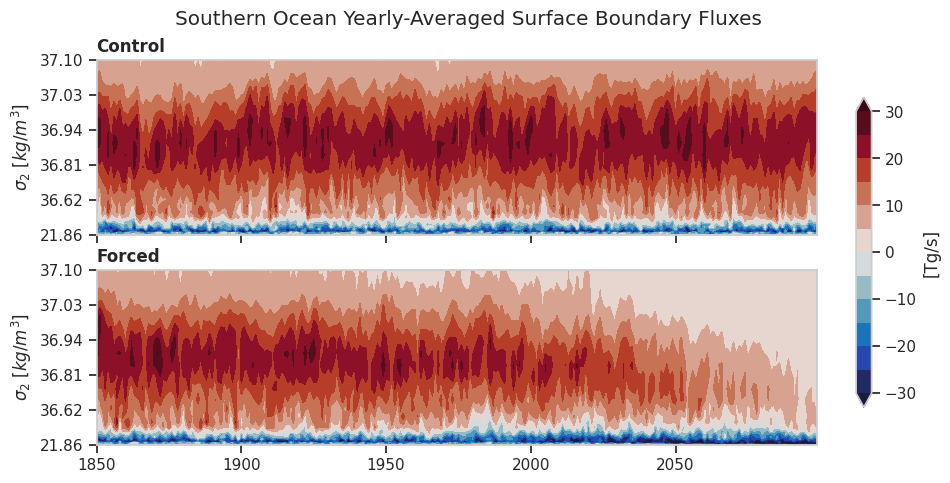

In [9]:
toTg = 1e-9 

fig, ax = plt.subplots(2, 1, figsize = (10, 5), sharex = True)

year = psi40_abyssal.year
density =  psi40_abyssal.sigma2_l_target
telescope_power = 50
transformed_density = density_transform(density, telescope_power)

TIME, DENS = np.meshgrid(year, transformed_density)

levels = np.arange(-30, 30 + 0.1, 5)
ax[0].contourf(TIME,DENS, 
               toTg * abyssal_sbf.sel(exp = "control").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

cm = ax[1].contourf(TIME,DENS, 
               toTg * abyssal_sbf.sel(exp = "forced").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

fig.colorbar(cm, ax = ax, orientation = "vertical", fraction = 0.02, label = "[Tg/s]")

fig.suptitle("Southern Ocean Yearly-Averaged Surface Boundary Fluxes ")
ax[0].set_title("Control", loc='left', fontweight = "bold")
ax[1].set_title("Forced", loc='left', fontweight = "bold")

formatter = create_density_formatter(density, transformed_density)

for a in ax: 
    a.tick_params(bottom=True, left=True)
    a.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
    a.yaxis.set_major_formatter(mticker.FuncFormatter(formatter))

# ax[1].invert_yaxis()

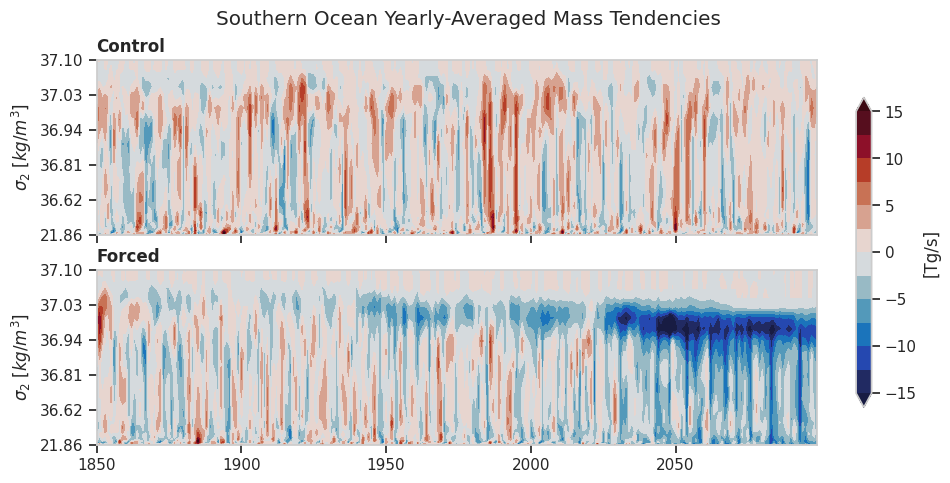

In [10]:
toTg = 1e-9 

fig, ax = plt.subplots(2, 1, figsize = (10, 5), sharex = True)

year = psi40_abyssal.year
density =  psi40_abyssal.sigma2_l_target
telescope_power = 50
transformed_density = density_transform(density, telescope_power)

TIME, DENS = np.meshgrid(year, transformed_density)

levels = np.arange(-15, 15 + 0.1, 2.5)
ax[0].contourf(TIME,DENS, 
               toTg * abyssal_dmdt.sel(exp = "control").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

cm = ax[1].contourf(TIME,DENS, 
               toTg * abyssal_dmdt.sel(exp = "forced").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

fig.colorbar(cm, ax = ax, orientation = "vertical", fraction = 0.02, label = "[Tg/s]")

fig.suptitle("Southern Ocean Yearly-Averaged Mass Tendencies ")
ax[0].set_title("Control", loc='left', fontweight = "bold")
ax[1].set_title("Forced", loc='left', fontweight = "bold")

formatter = create_density_formatter(density, transformed_density)

for a in ax: 
    a.tick_params(bottom=True, left=True)
    a.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
    a.yaxis.set_major_formatter(mticker.FuncFormatter(formatter))

# ax[1].invert_yaxis()

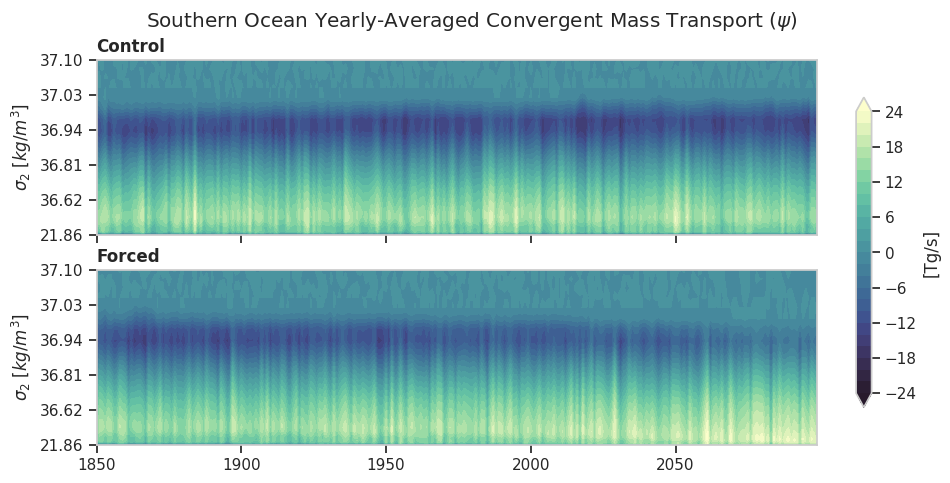

In [11]:
toTg = 1e-9 

fig, ax = plt.subplots(2, 1, figsize = (10, 5), sharex = True)

year = psi40_abyssal.year
density =  psi40_abyssal.sigma2_l_target
telescope_power = 50
transformed_density = density_transform(density, telescope_power)

TIME, DENS = np.meshgrid(year, transformed_density)

levels = np.arange(-24, 24 + 0.1, 2.0)
ax[0].contourf(TIME,DENS, 
               toTg * psi40_abyssal.sel(exp = "control").T, 
               levels = levels, extend = "both", cmap = cmo.deep_r)

cm = ax[1].contourf(TIME,DENS, 
               toTg * psi40_abyssal.sel(exp = "forced").T, 
               levels = levels, extend = "both", cmap = cmo.deep_r)

fig.colorbar(cm, ax = ax, orientation = "vertical", fraction = 0.02,  label = "[Tg/s]")

fig.suptitle("Southern Ocean Yearly-Averaged Convergent Mass Transport " + r"($\psi$)")
ax[0].set_title("Control", loc='left', fontweight = "bold")
ax[1].set_title("Forced", loc='left', fontweight = "bold")

formatter = create_density_formatter(density, transformed_density)

for a in ax: 
    a.tick_params(bottom=True, left=True)
    a.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
    a.yaxis.set_major_formatter(mticker.FuncFormatter(formatter))

# ax[1].invert_yaxis()

In [61]:
abyssal_sbf_crop = abyssal_sbf.sel(sigma2_l_target = slice(36.2, None))
abyssal_sbf_crop = abyssal_sbf_crop.where(abyssal_sbf_crop > 0)
max_locations = abyssal_sbf_crop.argmax("sigma2_l_target")

control_max = abyssal_sbf_crop["sigma2_l_target"][max_locations.sel(exp = "control")].rename("max_surface_boundary_flux_density")
forced_max = abyssal_sbf_crop["sigma2_l_target"][max_locations.sel(exp = "forced")].rename("max_surface_boundary_flux_density")

max_sbf_loc = xr.concat([control_max, forced_max], dim = "exp")

def select_from_max_location(ds, max_sbf_loc):
    """Select data from maximum locations in control and forced experiments."""
    results = {}
    
    for exp in ["control", "forced"]:
        exp_data = []
        for y in ds.year:
            # print(max_sbf_loc.sel(exp=exp, year=y))
            exp_data += [ds.sel(exp=exp, year=y).sel(sigma2_l_target=max_sbf_loc.sel(exp=exp, year=y).values)]
        results[exp] = xr.concat(exp_data, dim="year")
    
    return xr.concat(list(results.values()), dim="exp")

def select_from_yearly_max_location_monthly(ds, max_sbf_loc):
    """Select monthly data from maximum locations in control and forced experiments."""
    results = {}
    
    # First, add year as a coordinate if it doesn't exist
    if 'year' not in ds.coords:
        ds = ds.assign_coords(year=ds.time.dt.year)
    
    for exp in ["control", "forced"]:
        exp_monthly_data = []
        
        # Group by year
        for year, year_data in ds.sel(exp=exp).groupby('year'):
            # Get the max location for this year
            max_loc = max_sbf_loc.sel(exp=exp, year=year).values
            
            # Select data at this location for all months in this year
            selected_data = year_data.sel(sigma2_l_target=max_loc)
            
            # Add to our results
            exp_monthly_data.append(selected_data)
        
        # Combine all years for this experiment
        results[exp] = xr.concat(exp_monthly_data, dim="time")
    
    # Combine both experiments
    return xr.concat(list(results.values()), dim="exp")

# Apply the function to your monthly data
max_sbf_monthly = select_from_max_location_monthly(abyssal_sbf_crop_monthly, max_sbf_loc)
max_sbf = select_from_max_location(abyssal_sbf_crop, max_sbf_loc)

NameError: name 'select_from_max_location_monthly' is not defined

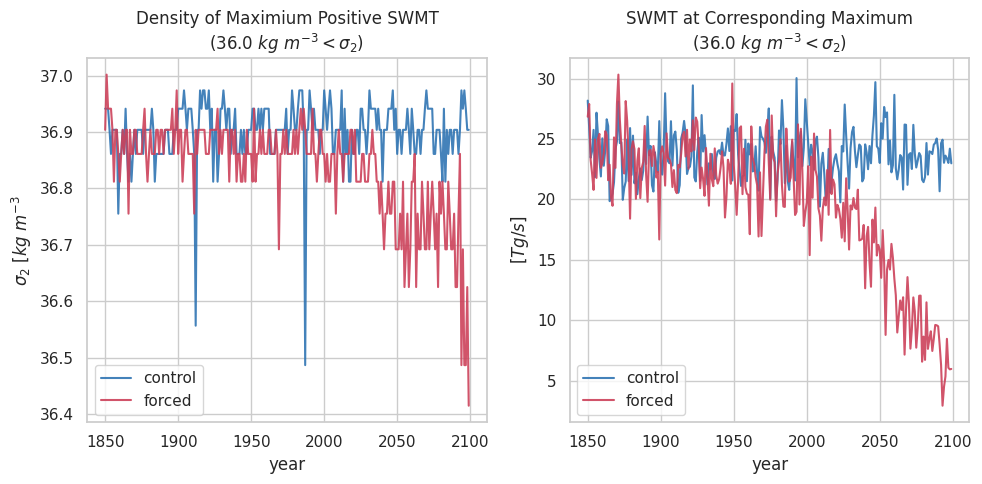

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
max_sbf_loc_rolling = max_sbf_loc.rolling(year=1, center=True).mean().dropna("year")
expts = ["control", "forced"]
for expt in expts:
    max_sbf_loc_rolling.sel(exp =expt).plot(ax = ax[0], c = expt_colors[expt], label = expt, alpha = .9)
ax[0].legend()
ax[0].set_ylabel(r"$\sigma_2 \ [kg\ m^{-3}$")
ax[0].set_title("Density of Maximium Positive SWMT\n" + r"($36.0\ kg\ m^{-3} < \sigma_2$)")

max_sbf_rolling = toTg * max_sbf.rolling(year=1, center=True).mean().dropna("year")
for expt in expts:
    max_sbf_rolling.sel(exp =expt).plot(ax = ax[1], c = expt_colors[expt], label = expt, alpha = .9)
ax[1].legend()
ax[1].set_ylabel(r"$[Tg/s]$")

ax[1].set_title("SWMT at Corresponding Maximum\n" + r"($36.0\ kg\ m^{-3} < \sigma_2$)")

fig.tight_layout()

In [70]:
ds_yearly_SWMT = get_SWMT(ds_yearly)
ds_yearly_SWMT = ds_yearly_SWMT.sel(sigma2_l_target = abyssal_sbf_crop.sigma2_l_target.values)
ds_yearly_SWMT_AABW = select_from_max_location(ds_yearly_SWMT, max_sbf_loc)
SWMT_difference = ds_yearly_SWMT_AABW.diff(dim = "exp")
SWMT_difference.coords["exp"] = ["difference"]
ds_yearly_SWMT_AABW = toTg * xr.merge([ds_yearly_SWMT_AABW, SWMT_difference])

In [71]:
ds_with_year = ds.assign_coords(year=ds.time.dt.year)
ds_SWMT = get_SWMT(ds_with_year).sel(sigma2_l_target = abyssal_sbf_crop.sigma2_l_target.values)
ds_SWMT_AABW =  toTg * select_from_yearly_max_location_monthly(ds_SWMT, max_sbf_loc)

[None, None, None]

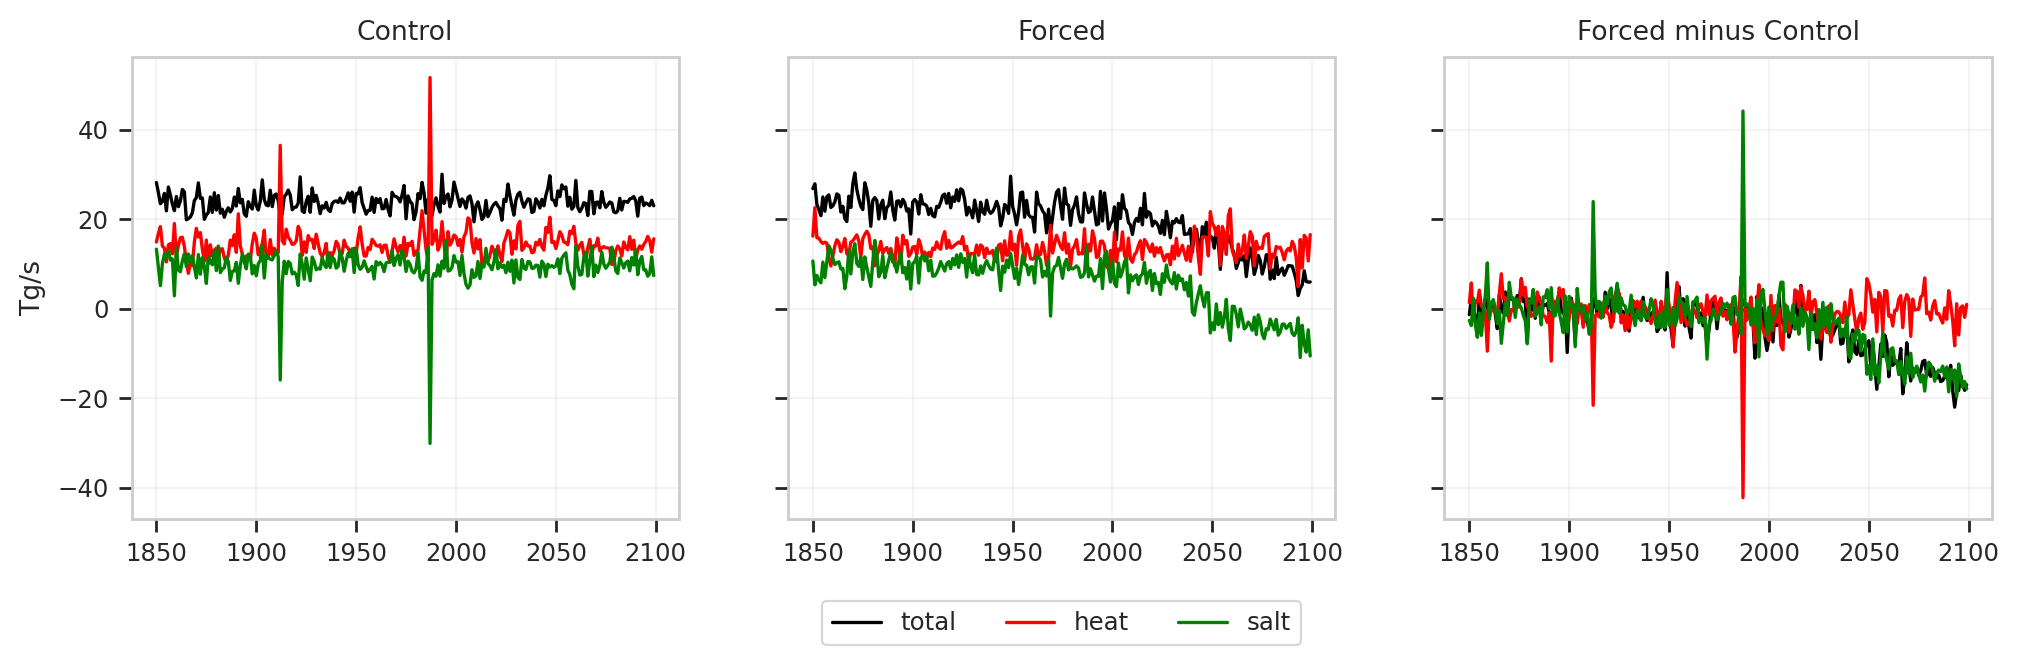

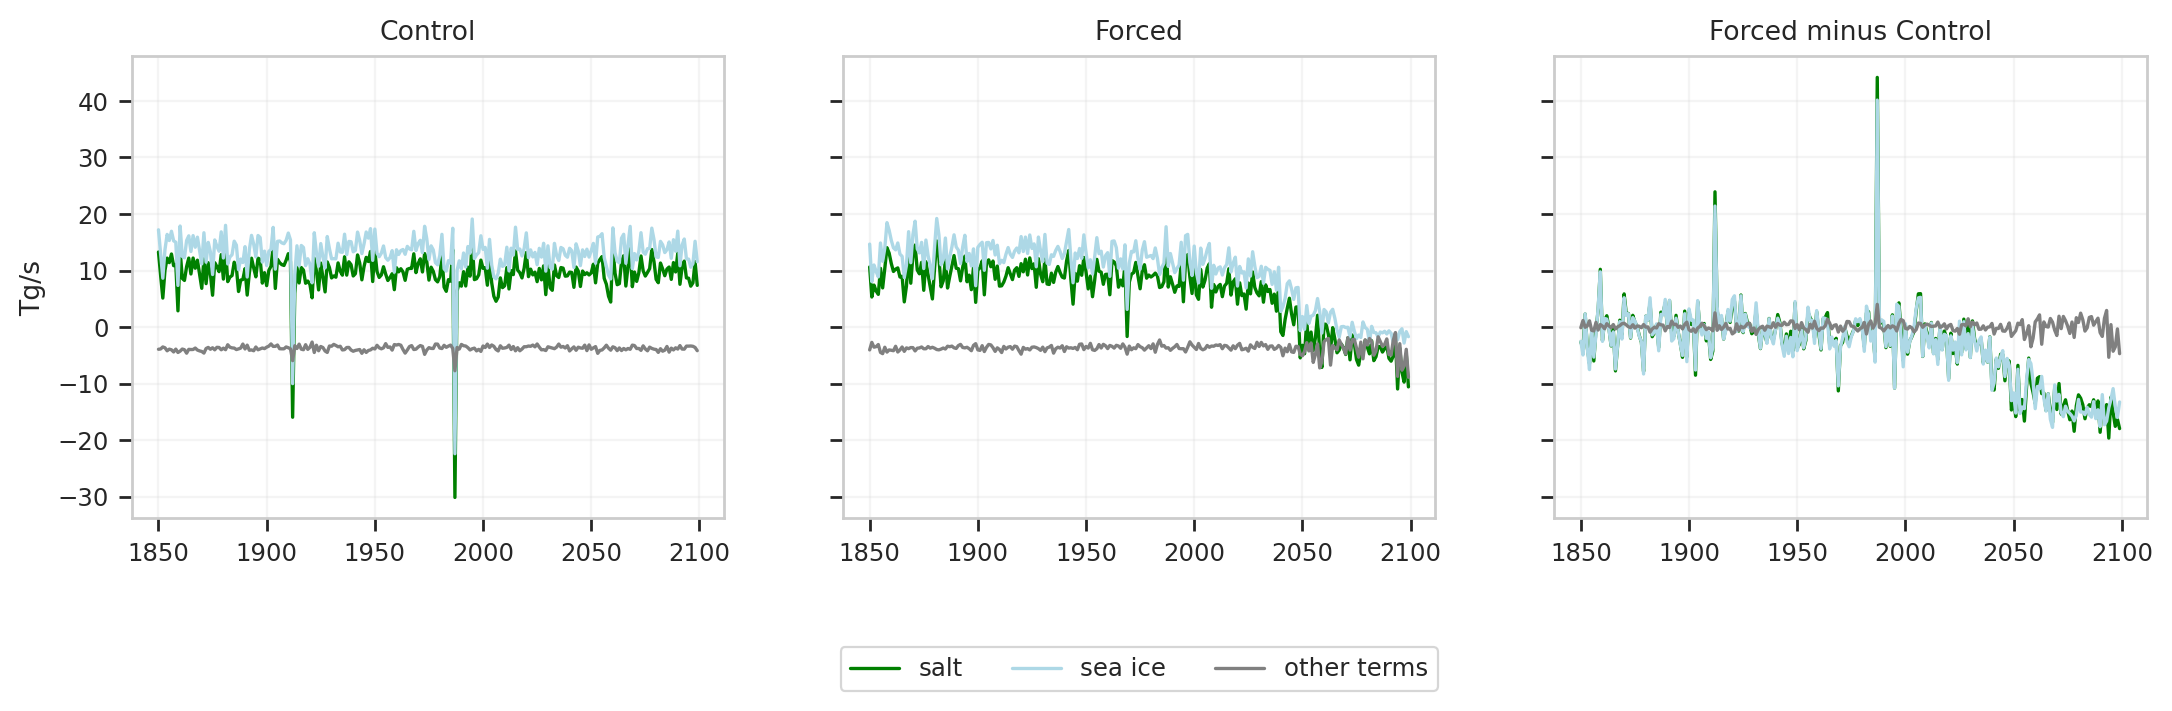

In [104]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3.0), sharey = True)
exps = ["control", "forced", "difference"]
time = ds_yearly_SWMT_AABW.year
for (i, expt) in enumerate(exps): 
    ax[i].plot(time, ds_yearly_SWMT_AABW["SWMT"].sel(exp = expt), c = "k", label = "total")
    ax[i].plot(time, ds_yearly_SWMT_AABW["SWMT_heat"].sel(exp = expt), label = "heat", c = "red")
    ax[i].plot(time, ds_yearly_SWMT_AABW["SWMT_salt"].sel(exp = expt), label = "salt", c = "green")

ax[0].set_title("Control")
ax[1].set_title("Forced")
ax[2].set_title("Forced minus Control")
ax[0].set_ylabel("Tg/s")
ax[1].legend(ncols = 3, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
[a.grid(alpha = 0.2) for a in  ax]
[a.tick_params(bottom=True, left=True) for a in  ax]

# fig.tight_layout()

fig, ax = plt.subplots(1, 3, figsize = (13, 3.0), sharey = True)
exps = ["control", "forced", "difference"]
time = ds_yearly_SWMT_AABW.year
for (i, expt) in enumerate(exps): 
    ax[i].plot(time, ds_yearly_SWMT_AABW["SWMT_salt"].sel(exp = expt), c = "green", label = "salt")
    ax[i].plot(time, ds_yearly_SWMT_AABW["SWMT_salt_sea_ice"].sel(exp = expt), label = "sea ice", c = "lightblue")

    otherterms = ds_yearly_SWMT_AABW["SWMT_salt"] - ds_yearly_SWMT_AABW["SWMT_salt_sea_ice"]
    ax[i].plot(time, otherterms.sel(exp = expt), label = "other terms", c = "grey")

    # ax[i].plot(time, (ds_yearly_SWMT_AABW["SWMT_salt_evaporation"] + ds_yearly_SWMT_AABW["SWMT_precipitation"]).sel(exp = expt), label = "evap/precip")
    # ax[i].plot(time, ds_yearly_SWMT_AABW["SWMT_salt_rivers"].sel(exp = expt), label = "rivers")
    # ax[i].plot(time, ds_yearly_SWMT_AABW["SWMT_salt_icebergs"].sel(exp = expt), label = "icebergs")
    # ax[i].plot(time, ds_yearly_SWMT_AABW["SWMT_salt_basal_salt"].sel(exp = expt), label = "basal salt")

ax[0].set_title("Control")
ax[1].set_title("Forced")
ax[2].set_title("Forced minus Control")
ax[1].legend(ncols = 3, loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3)
ax[0].set_ylabel("Tg/s")
[a.grid(alpha = 0.2) for a in  ax]
[a.tick_params(bottom=True, left=True) for a in  ax]
# fig.tight_layout()

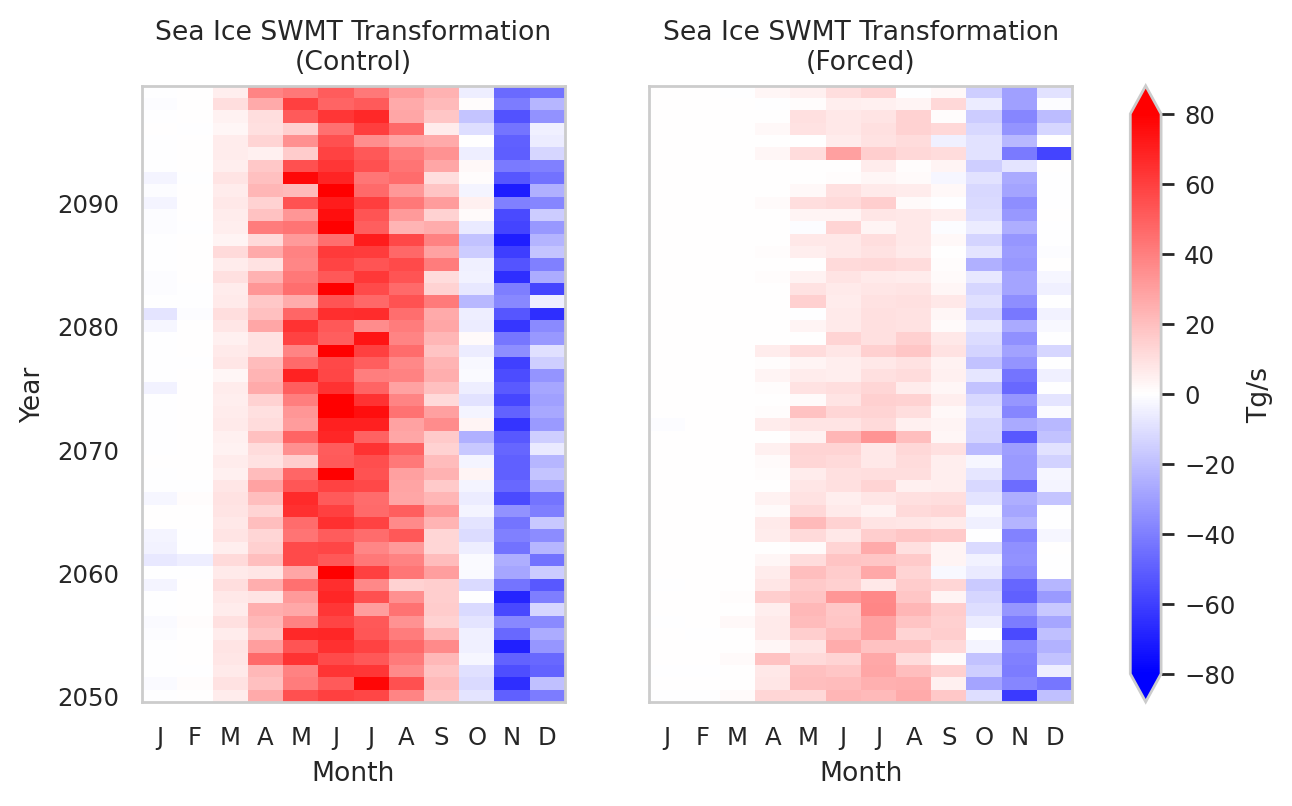

In [141]:
# Setup figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(7.5, 4), sharey=True)
experiments = ["control", "forced"]
titles = ["Control", "Forced"]

time_values = ds_SWMT_AABW["SWMT_salt_sea_ice"].sel(time=slice("2050", None)).time.values
datetime_values = [np.datetime64(t).astype(datetime.datetime) for t in time_values]

# Extract years and months
years = sorted(set(dt.year for dt in datetime_values))
months = np.arange(1, 13)

# Create 2D mesh grid for pcolormesh
month_mesh, year_mesh = np.meshgrid(months, years)

# Loop through experiments
for i, (exp, title) in enumerate(zip(experiments, titles)):
    # Get data for this experiment
    data = ds_SWMT_AABW["SWMT_salt_sea_ice"].sel(time=slice("2050", None)).sel(exp=exp)
    
    # Create data array for the mesh
    mesh_data = np.full((len(years), len(months)), np.nan)
    
    # Fill the data array
    for t_idx, t in enumerate(time_values):
        dt = np.datetime64(t).astype(datetime.datetime)
        year_idx = years.index(dt.year)
        month_idx = dt.month - 1  # 0-indexed
        mesh_data[year_idx, month_idx] = data.isel(time=t_idx).values
    
    # Create pcolormesh plot
    pcm = axes[i].pcolormesh(month_mesh, year_mesh, mesh_data, 
                           cmap='bwr', vmin = -80, vmax = 80)
    axes[i].set_title(f"Sea Ice SWMT Transformation\n({title})")

for (i, a) in enumerate(axes):
    # Set labels and ticks
    a.set_xlabel("Month")
    if i == 0:
        axes[i].set_ylabel("Year")
    
    a.set_xticks(months)
    a.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    
cbar = fig.colorbar(pcm, ax=axes, label = "Tg/s", extend = "both")

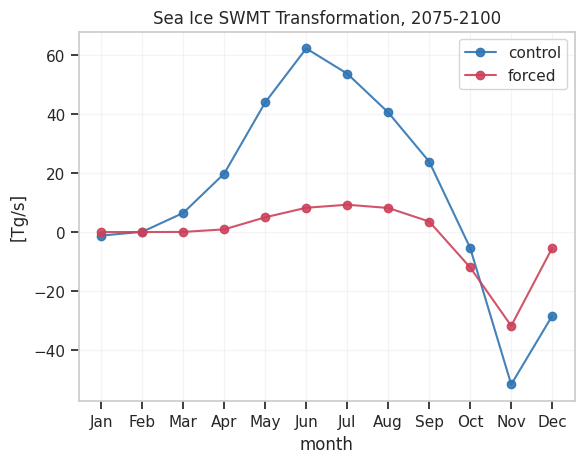

In [161]:
times = ("2075", "2100")
data = ds_SWMT_AABW["SWMT_salt_sea_ice"].sel(time = slice(times[0], times[1]))
data = data.groupby("time.month").mean("time")

fig, ax = plt.subplots()
for expt in ["control", "forced"]: 
    data.sel(exp = expt).plot(ax = ax, c = expt_colors[expt], label = expt, alpha = .9, marker = "o")

ax.set_ylabel("[Tg/s]")
ax.set_title(f"Sea Ice SWMT Transformation, " + '-'.join(times))
ax.legend()
ax.grid(alpha = 0.2)
ax.tick_params(bottom=True, left=True)
ax.set_xticks(data.month)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);

In [162]:
ds_sfc = xr.open_mfdataset(datadir(f"/model/Southern_Ocean_Surface_Advection_and_Tendency_sigma_slice.nc"))
ds_sfc_SWMT = get_SWMT(ds_sfc)
ds_sfc_SWMT = select_from_max_location(ds_sfc_SWMT, max_sbf_loc).compute()

In [87]:
mass_flux_units_conversion = toTg / (ds_sfc_SWMT.areacello / (100e3 **2 ))
mass_flux_units = r"$Tg/100^2 km^2 / s$"

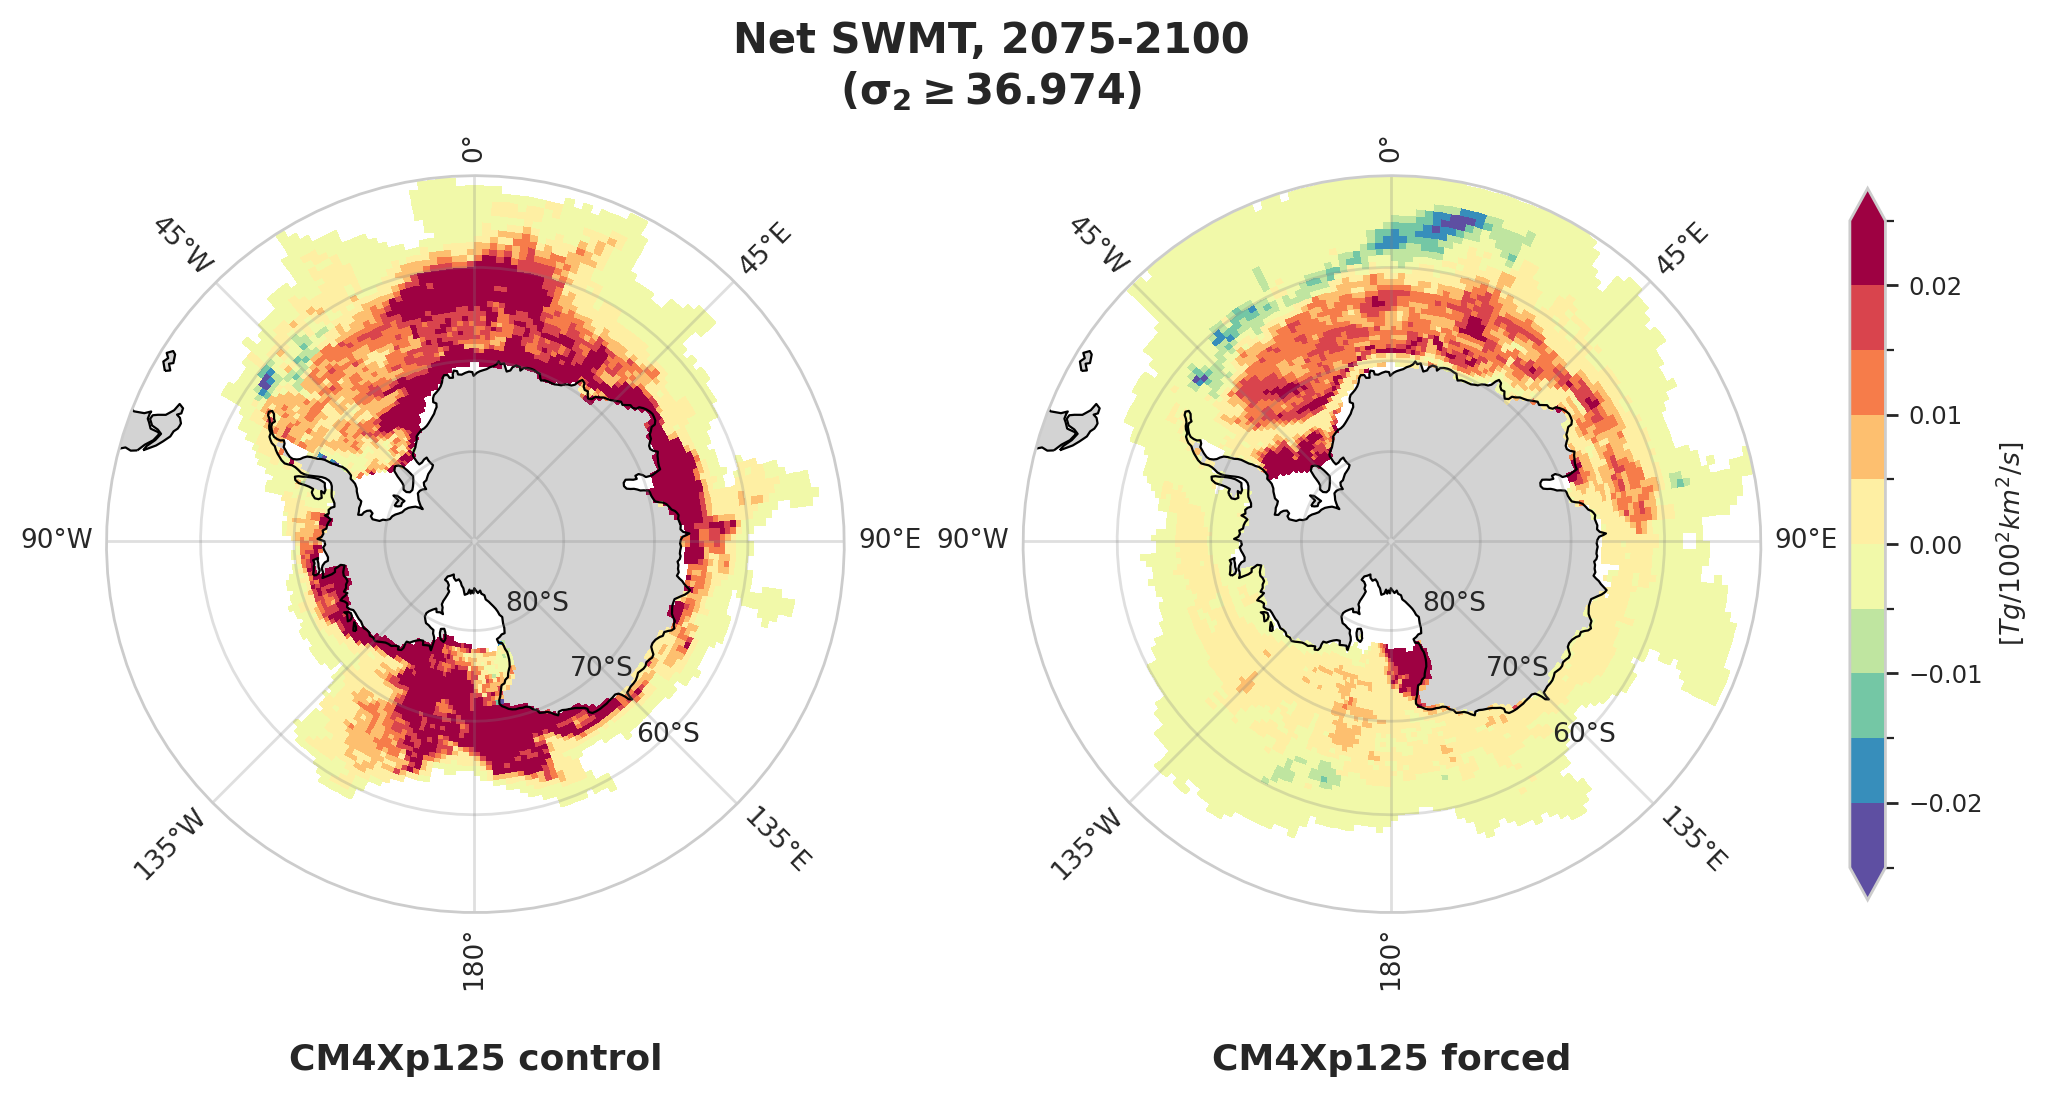

In [164]:
experiments = ['control', 'forced']
nexpt = len(experiments)
sns.set_style("whitegrid")
sns.set_context("paper")
mpl.rcParams['figure.dpi'] = 200

density_title = r"$\mathbf{(\sigma_2 \geq 36.974)}$"
cmap = plt.get_cmap('Spectral_r')
# boundaries = np.arange(-0.02, 0.0201, 0.005)
# boundaries = np.arange(-0.05, 0.0501, 0.01)
boundaries = np.arange(-0.05, 0.0501, 0.01) / 2

boundaries[np.abs(boundaries) < 1e-16]  = 0
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -50], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = (2075, 2100)

wmt_mean = ds_sfc_SWMT.sel(year = slice(times[0], times[1])).mean("year")
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    cm = plot_antarctic_plot(wmt_mean, ax[i], cmap = cmap, norm = norm, 
                       exp = exp, variable = "SWMT", 
                        mass_flux_units_conversion = mass_flux_units_conversion)
        
fig.suptitle("Net SWMT, " + '-'.join(list(map(str, times))) + "\n" + density_title, 
             fontweight = "bold", fontsize = 15, ha='center')


fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both")

# fig.savefig(plotsdir(f"paper_figures/dMdt_sigma_{sigma}_surface.png"), bbox_inches = "tight", dpi = dpi)


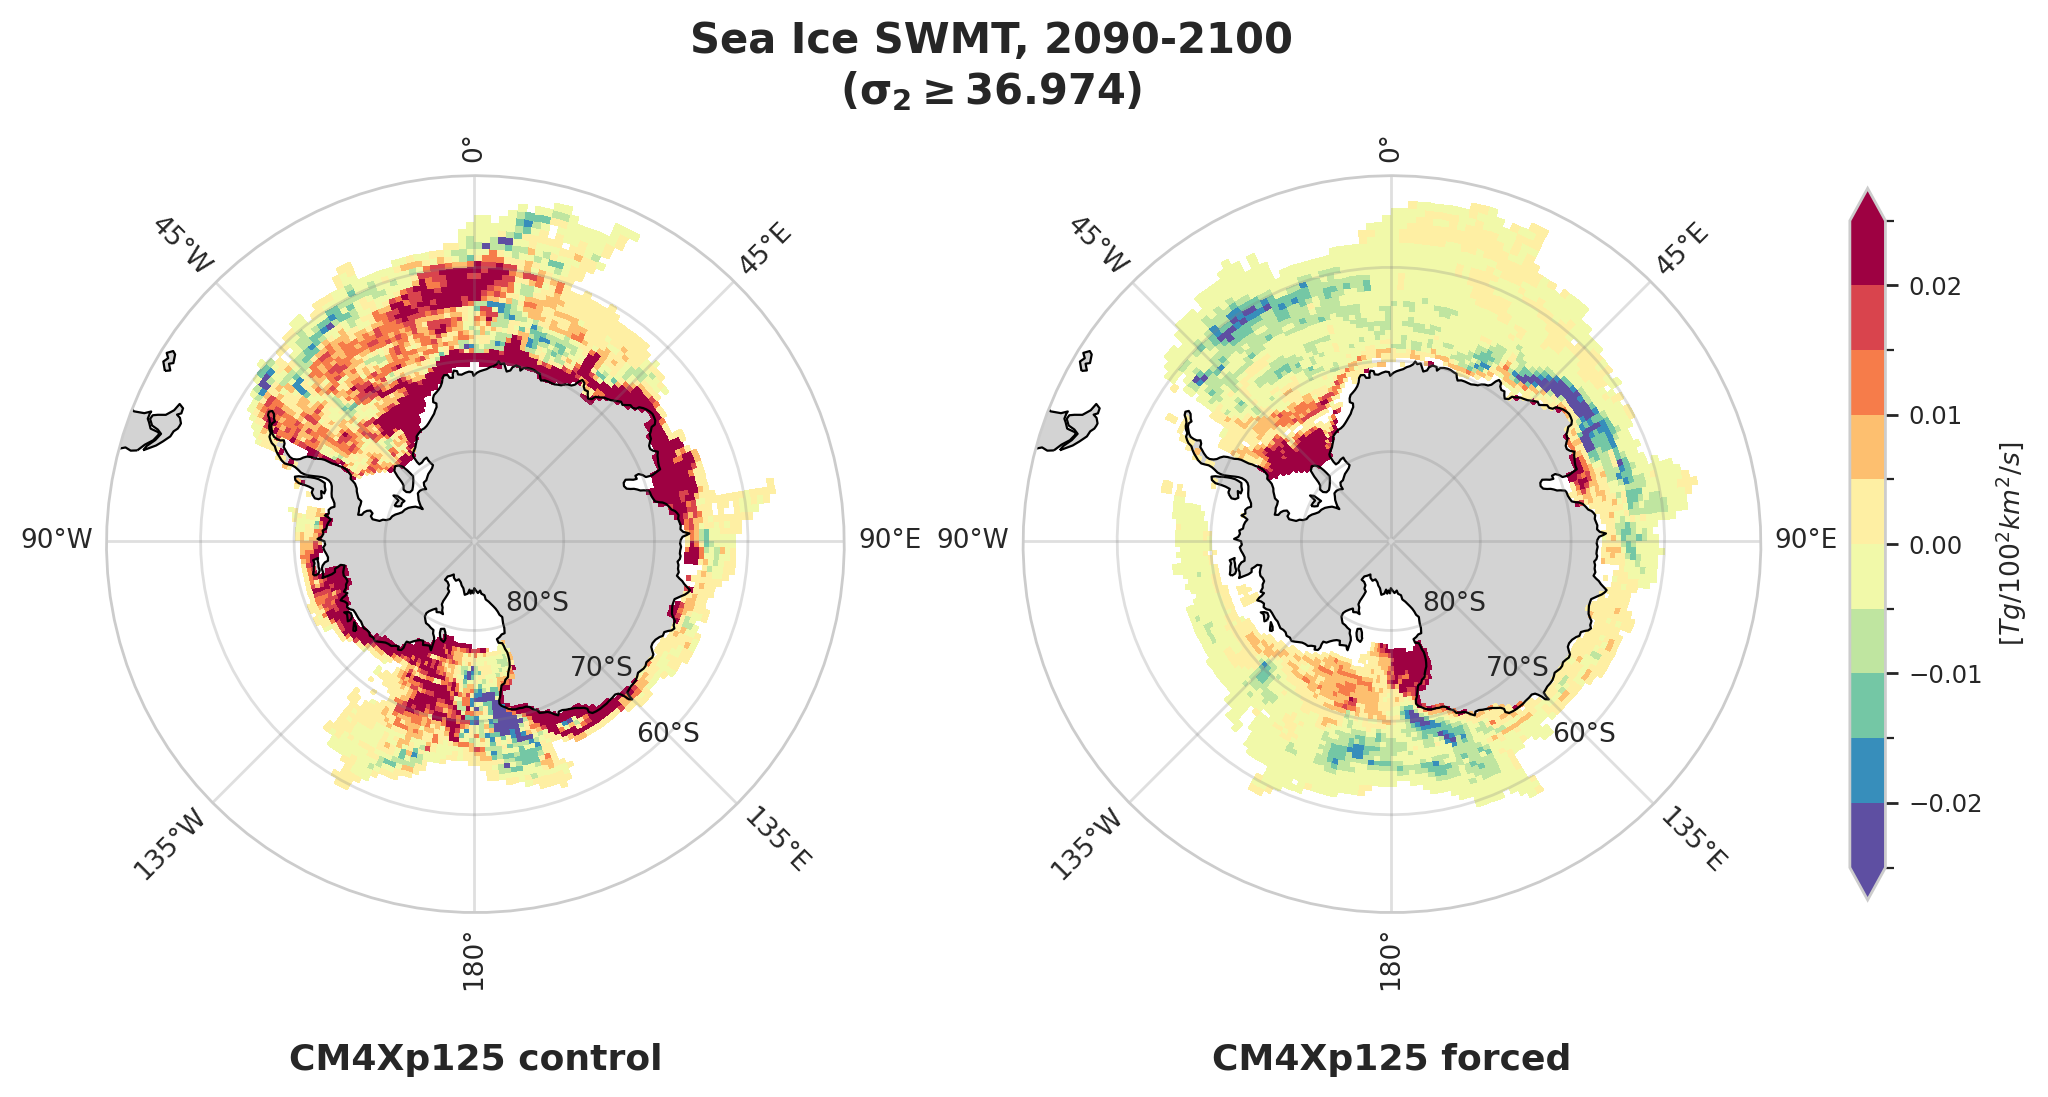

In [95]:
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -50], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25

wmt_mean = ds_sfc_SWMT.sel(year = slice(times[0], times[1])).mean("year")
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    cm = plot_antarctic_plot(wmt_mean, ax[i], cmap = cmap, norm = norm, 
                       exp = exp, variable = "SWMT_salt_sea_ice", 
                        mass_flux_units_conversion = mass_flux_units_conversion)
        
fig.suptitle("Sea Ice SWMT, " + '-'.join(list(map(str, times))) + "\n" + density_title, 
             fontweight = "bold", fontsize = 15, ha='center')


fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both")

# fig.savefig(plotsdir(f"paper_figures/dMdt_sigma_{sigma}_surface.png"), bbox_inches = "tight", dpi = dpi)


In [170]:
ds_sfc_props = xr.open_mfdataset(datadir(f"/model/Southern_Ocean_Yearly_Surface_Fluxes_And_Properties.nc"))
ds_sfc_props["z"] = 0
ds_sfc_props = ds_sfc_props.where(ds_sfc_props.wet > 0)
ds_sfc_props["sigma2"] = calc_sigma2(ds_sfc_props.rename({"tos":"thetao", "sos":"so"}), mask_inactive_layers = False)

ds_sfc_props = ds_sfc_props.compute()

using geolatlon


In [208]:
salt_flux_units_conversion = (100e3 **2 ) / 1000 #g/m^2/s -> kg / (100km^2)/ s
salt_flux_units = r"$kg/100^2 km^2 / s$"

In [209]:
times_int = [int(t) for t in times]

In [210]:
max_control_boundary = max_sbf_loc.sel(exp = "control").sel(year = slice(times_int[0], times_int[1])).mean("year").values
max_forced_boundary = max_sbf_loc.sel(exp = "forced").sel(year = slice(times_int[0], times_int[1])).mean("year").values

(0, 'DJF')
(1, 'MAM')
(2, 'JJA')
(3, 'SON')
(0, 'DJF')
(1, 'MAM')
(2, 'JJA')
(3, 'SON')


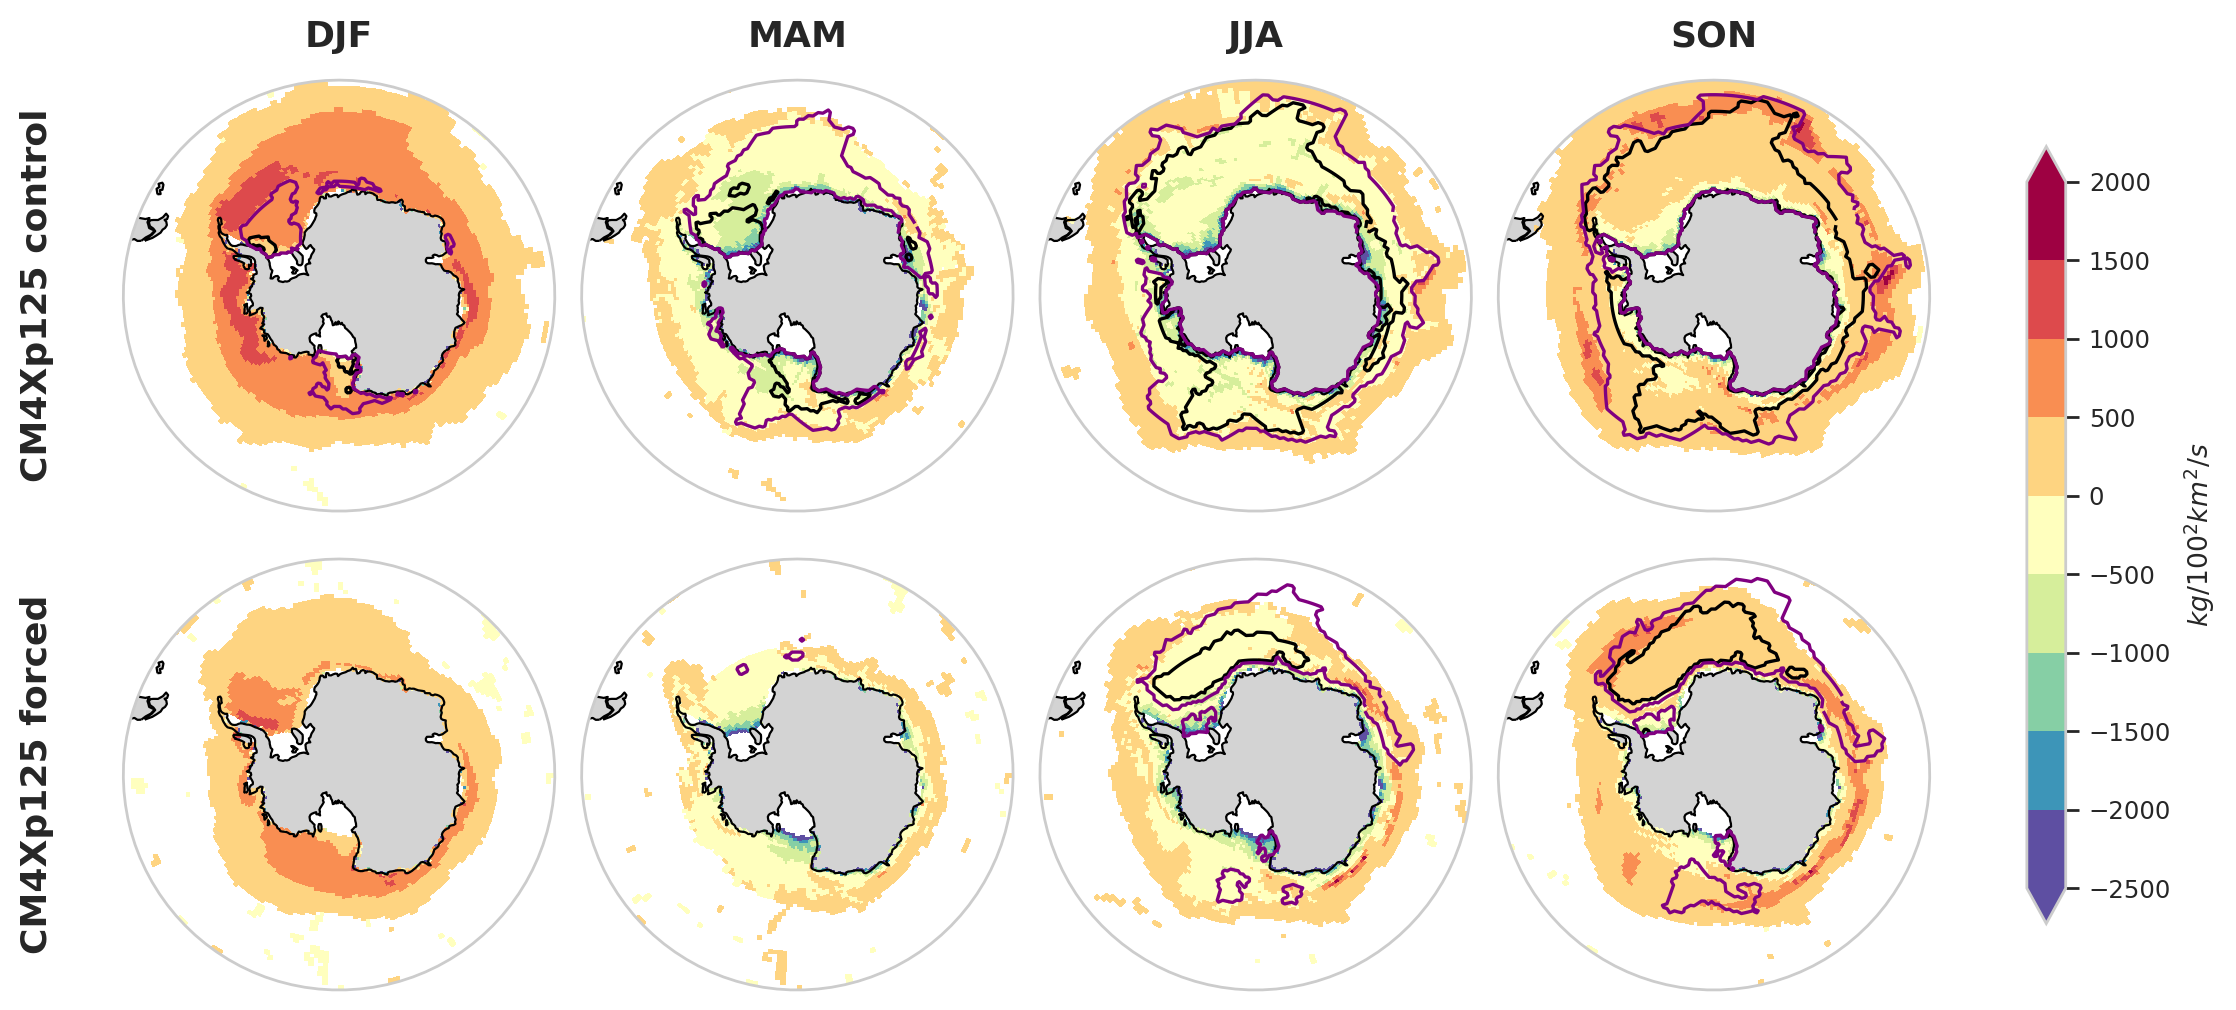

In [213]:
boundaries = np.arange(-2500, 2500 + 1e-16, 500)
boundaries[np.abs(boundaries) < 1e-16]  = 0
boundaries
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

fig, ax = plt.subplots(2, 4, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -50], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25

wmt_mean = ds_sfc_props.sel(time = slice(times[0], times[1]))
wmt_mean = wmt_mean.groupby("time.season").mean("time")
wmt_mean["fsitherm"] = wmt_mean["fsitherm"].where(np.abs(wmt_mean["fsitherm"]) > 1e-8)
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    for (j, season) in enumerate(["DJF", "MAM", "JJA", "SON"]):
        print((j, season))
        cm = plot_antarctic_plot(wmt_mean.sel(season = season), ax[i, j], cmap = cmap, norm = norm, 
                           exp = exp, variable = "fsitherm", 
                            mass_flux_units_conversion = salt_flux_units_conversion, 
                                 draw_gridlines = False)
        
        water_mass_boundary = wmt_mean.sel(season = season)["sigma2"].sel(exp = exp)
        water_mass_boundary = water_mass_boundary >= max_control_boundary
        cb = ax[i, j].contour(water_mass_boundary.geolon, water_mass_boundary.geolat, 
             water_mass_boundary, transform=ccrs.PlateCarree(), 
            colors = "k")
        
        water_mass_boundary = wmt_mean.sel(season = season)["sigma2"].sel(exp = exp)
        water_mass_boundary = water_mass_boundary >= max_forced_boundary
        cb = ax[i, j].contour(water_mass_boundary.geolon, water_mass_boundary.geolat, 
             water_mass_boundary, transform=ccrs.PlateCarree(), 
            colors = "purple")

# fig.suptitle("Mass Tendency, " + '-'.join(list(map(str, times))) + "\n" + density_title, 
#              fontweight = "bold", fontsize = 15, ha='center')


fig.tight_layout()

for a, row in zip(ax[:, 0], experiments):
    a.annotate("CM4Xp125 " + row, xy=(-0.2, 0.5), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold", 
                rotation=90)

for a, season in zip(ax[0, :], ["DJF", "MAM", "JJA", "SON"]):
    a.annotate(season, xy=(0.5, 1.1), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold", 
                rotation=0)
    
fig.colorbar(cm, ax = ax[:], label = f"{salt_flux_units}", fraction = 0.02, extend = "both")

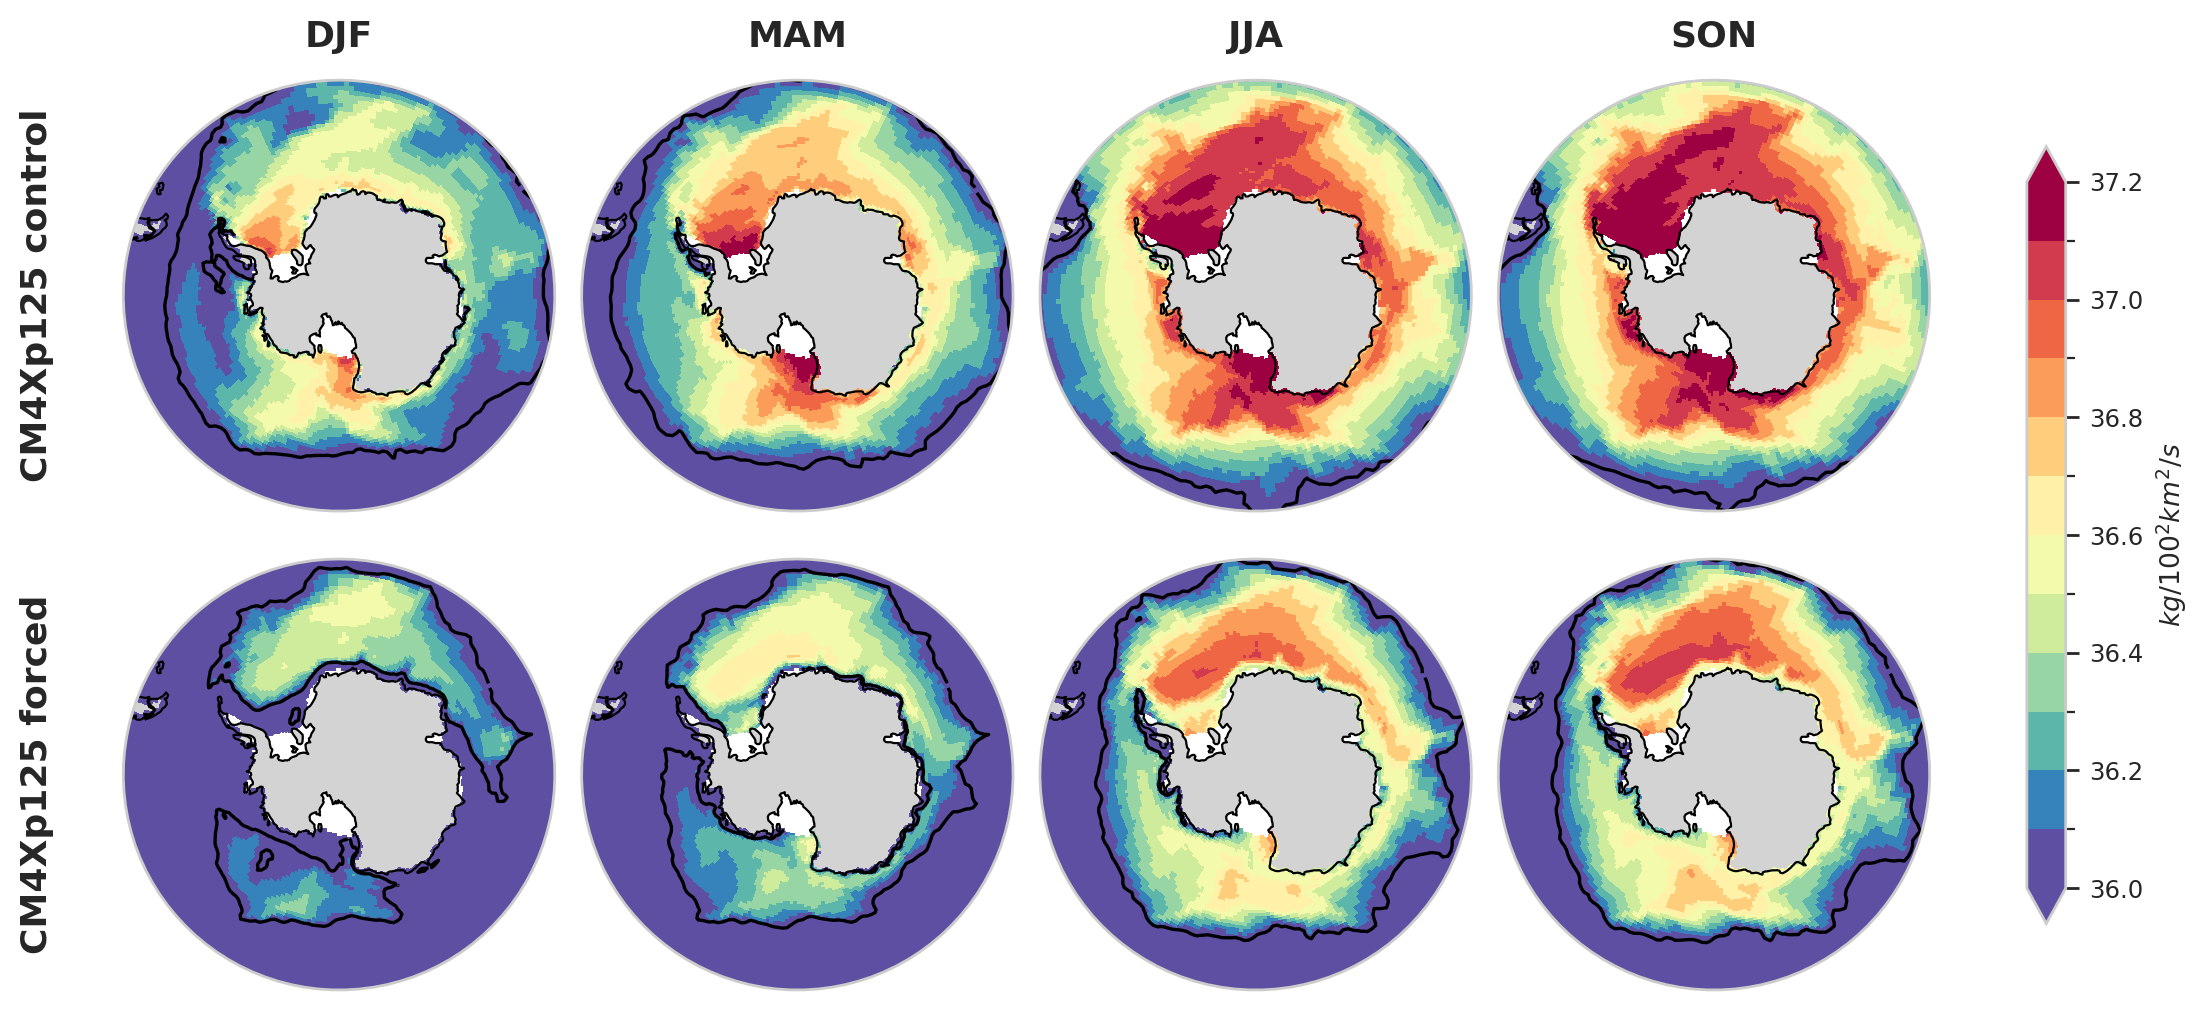

In [214]:
boundaries = np.arange(36, 37.3, 0.1)
cmap = plt.get_cmap('Spectral_r')

norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

fig, ax = plt.subplots(2, 4, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -50], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2075", "2100")

wmt_mean = ds_sfc_props.sel(time = slice(times[0], times[1]))
wmt_mean = wmt_mean.groupby("time.season").mean("time")

curr_width = 0.0
for (i, exp) in enumerate(experiments):
    for (j, season) in enumerate(["DJF", "MAM", "JJA", "SON"]):
        cm = plot_antarctic_plot(wmt_mean.sel(season = season), ax[i, j], cmap = cmap, norm = norm, 
                           exp = exp, variable = "sigma2", 
                            mass_flux_units_conversion = 1, 
                                 draw_gridlines = False)
        cb = ax[i, j].contour(wmt_mean.geolon, wmt_mean.geolat, 
                     wmt_mean.sel(season = season)["sigma2"].sel(exp = exp), transform=ccrs.PlateCarree(), 
                    colors = "k")
# fig.suptitle("Mass Tendency, " + '-'.join(list(map(str, times))) + "\n" + density_title, 
#              fontweight = "bold", fontsize = 15, ha='center')


fig.tight_layout()

for a, row in zip(ax[:, 0], experiments):
    a.annotate("CM4Xp125 " + row, xy=(-0.2, 0.5), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold", 
                rotation=90)

for a, season in zip(ax[0, :], ["DJF", "MAM", "JJA", "SON"]):
    a.annotate(season, xy=(0.5, 1.1), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold", 
                rotation=0)
    
fig.colorbar(cm, ax = ax[:], label = f"{salt_flux_units}", fraction = 0.02, extend = "both")